In [57]:
from scipy.optimize import minimize
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
from scipy import linalg
from scipy.linalg import block_diag

In [58]:
def visualize_matrix(A, rng = 5):
    
    A = np.log(np.abs(A) + 1e-9) 
    #A = np.log(A + 1)
    
  #  if(rng == -1):
  #      rng = np.max(np.max(np.abs(A)))
    
  #  A = np.abs()
    plt.matshow(A, vmin=-rng, vmax=rng)
    plt.colorbar()

    #plt.imshow(A)
   # plt.colorbar()
   # plt.show()

In [88]:
def fit(A, x):
    return A.dot(x)

def l1_der(params, A, b):
    b_hat = fit(A, params) - b
    return (A.T).dot( np.sign(b_hat) )

def l1_loss(params, A, b):
    return np.sum(np.abs(b - fit(A, params)))

def huber(A, epsilon = 1.0):
    abs_linear_loss = np.abs(A)
    abs_linear_loss = np.reshape(abs_linear_loss, -1)
    outliers_mask = abs_linear_loss > epsilon
    
    outliers = abs_linear_loss[outliers_mask]
    inliers = abs_linear_loss[~outliers_mask]
    
    square_loss = 0.5 * np.dot(inliers.T, inliers)
    outlier_loss = epsilon * sum(outliers - 0.5 * epsilon)
    
    return square_loss + outlier_loss
    

def huber_der(params, A, b, epsilon = 1.0):
    b_hat = fit(A, params) - b
    return (A.T).dot( np.where( np.abs(b_hat) > epsilon, epsilon * np.sign(b_hat) , b_hat ) )

def huber_loss(params, A, b, epsilon = 1.0):
    linear_loss = fit(A, params) - b
    abs_linear_loss = np.abs(linear_loss)
    outliers_mask = abs_linear_loss > epsilon
    
    outliers = abs_linear_loss[outliers_mask]
    inliers = abs_linear_loss[~outliers_mask]
    
    square_loss = 0.5 * np.dot(inliers.T, inliers)
    outlier_loss = epsilon * sum(outliers - 0.5 * epsilon)
    
    return square_loss + outlier_loss

def l1_regression(A, b):
    
    x0 = np.random.randn(np.shape(A)[1])
    output = minimize(l1_loss, x0, args=(A, b), jac = l1_der)
    
    return output.x, l1_loss(output.x, A, b)

def huber_regression(A, b, epsilon = 1.0):
    
    x0 = np.random.randn(np.shape(A)[1])
    output = minimize(huber_loss, x0, args=(A, b, epsilon), jac = huber_der)
    
    return output.x, huber_loss(output.x, A, b)

In [60]:
#return B, V, total_loss, B.dot(V) is the low rank approximation

def low_rank_approx(A, k, func = 'huber', epsilon = 1.0, verbose = False):
    loss_functions = {
        "huber": (huber_regression, epsilon),
        "l1": (l1_regression, )
    }
    
    loss = loss_functions[func][0]
    args = loss_functions[func][1:]
    
    #########################
    
    col_thr = 4 * k
    num_col = 2 * k
    frac = 1. / 2.
    num_repeat = 20
    
    #########################

    A_t = A
    rnd = 0
    
    while(np.shape(A_t)[1] > col_thr):
        
        rnd = rnd + 1
        
        m = np.shape(A_t)[1]
        num_fits = int(num_col + np.floor((m - num_col) * frac))
        
        best_base_col = np.array([[]])
        best_fitted = []
        best_loss = math.inf
        
        for itr in range(num_repeat):
            
            if(itr % 10 == 9 and verbose == True):
                print("iteration:",rnd,'-',itr + 1)
            
            pos = np.random.permutation(m)
            base_col = A_t[ :, pos[:num_col] ]
            cur_losses = np.array([0] * m)
            
            for i in range(m):
                cur_param, cur_losses[i] = loss(base_col, A_t[:, i], *args)
            
            sorted_loss = sorted(range(m), key = lambda k : cur_losses[k])
            cur_loss = sum(cur_losses[ sorted_loss[:num_fits] ])
            
            if(cur_loss < best_loss):
                best_loss = cur_loss
                best_fitted = sorted_loss[:num_fits]
                best_base_col = base_col
        
        if(rnd > 1):
            B = np.append(B, best_base_col, axis = 1)
        else:
            B = best_base_col
        remain = np.array([0] * m)
        remain[best_fitted] = 1
        remain = [c == 0 for c in remain]
        A_t = A_t[:, remain]
    
    n = np.shape(A)[0]
    d = np.shape(A)[1]
    b_rank = np.shape(B)[1]
    
    V = np.zeros([b_rank, d])
    final_loss = 0
    for i in range(d):
        V[:, i], cur_loss = loss(B, A[:, i], *args)
        final_loss = final_loss + cur_loss
        
    return B, V, final_loss

In [61]:
def F_low_rank_approx(A, k):
    U, s, Vh = linalg.svd(A, full_matrices=False)
    t = s
    t[k:] = 0
    S = np.diag(t)
    
    return U.dot(S).dot(Vh), sum(sum((U.dot(S).dot(Vh)-A)*(U.dot(S).dot(Vh)-A)))
    

In [72]:
def L1_low_rank_approx_one_time(A, k):
    
    t = 4 * k
    t1 = t
    t2 = 3 * t1
    
    n = np.shape(A)[0]
    d = np.shape(A)[1]
    
    S = np.random.standard_cauchy([t1, n])
    R = np.random.standard_cauchy([d, t1])
    
    if(t2 < n):
        T1 = np.random.standard_cauchy([t2, n])
    else:
        T1 = np.identity(n)
    if(t2 < d):
        T2 = np.random.standard_cauchy([d, t2])
    else:
        T2 = np.identity(n)
    
    L = T1.dot(A).dot(R)
    N = S.dot(A).dot(T2)
    M = T1.dot(A).dot(T2)
    
    L_inv = np.linalg.pinv(L)
    N_inv = np.linalg.pinv(N)
    
    Y = L.dot(L_inv).dot(M).dot(N_inv).dot(N)
    UY, sy, VY = linalg.svd(Y, full_matrices=False)
    ty = sy
    ty[k:] = 0
    
    SY = np.diag(ty)
    
    X_hat = L_inv.dot(UY).dot(SY).dot(VY).dot(N_inv)
    
    return A.dot(R).dot(X_hat).dot(S).dot(A), sum(sum(np.abs(A.dot(R).dot(X_hat).dot(S).dot(A) - A)))

def L1_low_rank_approx(A, k):
    
    num_repeat = 1000
    best_loss = math.inf
    best_B = None
    
    for _ in range(num_repeat):
        B, loss = L1_low_rank_approx_one_time(A, k)
        if(loss < best_loss):
            best_loss = loss
            best_B = B
            
    return best_B, best_loss

In [84]:
def gen_matrix(n=500, k = 14):
    
    scalar = np.sqrt(n) / 5
    
    large = np.ones(k) * n * n**0.3 / 4
    A1 = np.diag(large)
    
    m = int(np.floor(n * 4 / 5))
    
    #U2 = np.random.randn(m, k)
    #V2 = np.random.randn(k, m)
    #A2 = U2.dot(V2)/np.sqrt(k)
    
    m = int(m / k) * k
    t = int(m / k)
    
    
    X = np.random.randn(m, k)
    X = np.where(X > 0 , 1, -1)
    A2 = X
    for _ in range(t - 1):
        A2 = np.append(A2, X, axis = 1)
    
    
    q = int(np.floor(n**0.6))
    
    U = np.random.randn(q, k)
    V = np.random.randn(k, q)
    A3 = U.dot(V) / np.sqrt(k)
    
    A1 = A1 / scalar
    A2 = A2 / scalar

    A = block_diag(A2,A3,A1)
    
    #print(sum(sum(np.abs(A2))))
    #print(sum(sum(np.abs(A3))))
    #print(sum(sum(np.abs(A1))))
    
    remain_n = n - np.shape(A)[0]
    
    A = block_diag(A, np.zeros([remain_n, remain_n]))
    
    return A

In [85]:
def demo_images():

    A = gen_matrix()
    #print(A)
    visualize_matrix(A)
    
    B, loss = L1_low_rank_approx(A, 14)
    print(loss)
    visualize_matrix(B)
    
    B, loss = F_low_rank_approx(A, 14)
    print(loss)
    visualize_matrix(B)
    
    B, V, loss = low_rank_approx(A, 1)
    print(loss)
    print(np.shape(B))
    visualize_matrix(B.dot(V))

In [86]:
def cmp_diffierent_low_rank_approx():
    
    np.random.seed(10)
    
    N = [200, 300, 400, 500]
    K = [ 12, 12, 14, 14]
    
    loss1 = np.zeros(4)
    loss2 = np.zeros(4)
    loss3 = np.zeros(4)
    
    for i in range(4):
        n = N[i]
        k = K[i]
        A = gen_matrix(n, k)
        
        B, loss = L1_low_rank_approx(A, k)
        loss1[i] = huber(B - A)
        
        B, loss = F_low_rank_approx(A, k)
        loss2[i] = huber(B - A)
        
        B, V, loss = low_rank_approx(A, i + 1)
        loss3[i] = loss
    
    print("loss1:", loss1)
    print("loss2:", loss2)
    print("loss3:", loss3)

34360.3149694527
1379.126911972905
2524.724835337624
13570.617993471415
9538.26599303785
4384.897147842191
(500, 14)


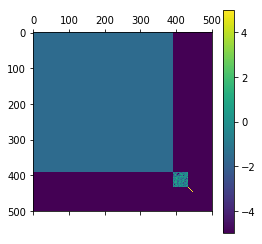

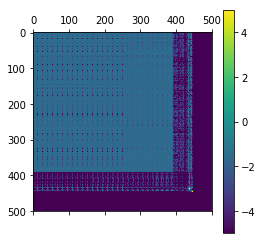

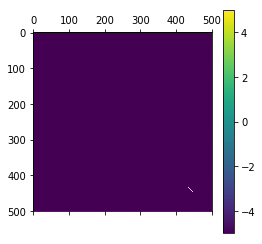

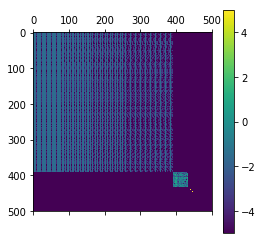

In [76]:
demo_images()

In [89]:
cmp_diffierent_low_rank_approx()

loss1: [1965.68700041 2678.50733404 4085.57163448 5851.28804622]
loss2: [1733.37441543 2766.72626692 3497.60331721 4630.52018674]
loss3: [1510.36039382 1296.72563266 1351.31532525 1258.86241767]
